<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Slant_Puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random
from pyomo.contrib.latex_printer import latex_printer

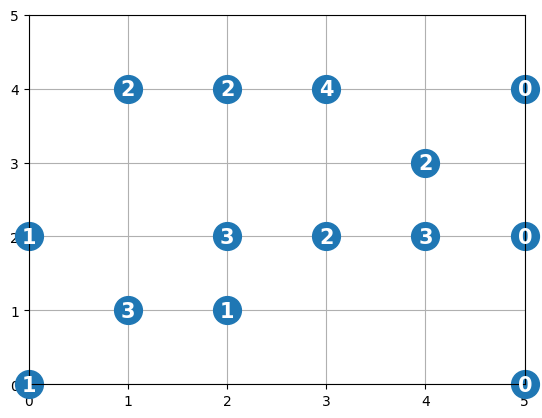

In [125]:
x = [0,0,1,1,2,2,2,3,3,4,4,5,5,5]
y = [0,2,1,4,1,2,4,2,4,2,3,0,2,4]
val = [1,1,3,2,1,3,2,2,4,3,2,0,0,0]

plt.xlim(0,5)
plt.ylim(0,5)

plt.scatter(x,y,marker = 'o', s = 400, clip_on=False, alpha = 1, zorder = 2)
for i in range(len(x)):
  plt.text(x[i]-.07,y[i]-.09,val[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3)

plt.grid(True, which = 'major', zorder = 1)
#plt.savefig('pic1.png')
plt.show()

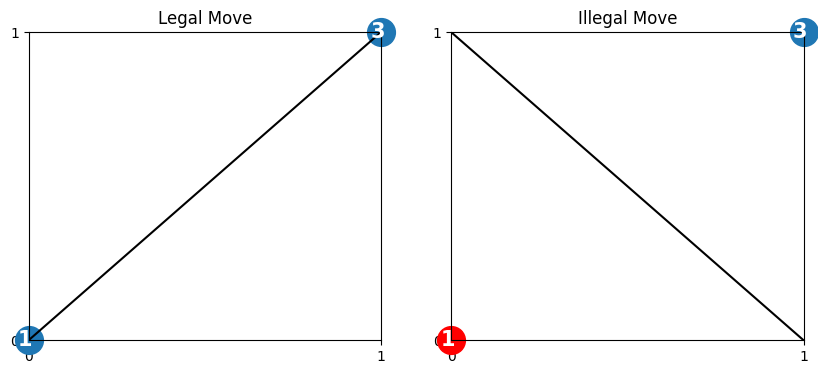

In [3]:
# plt.xlim(0,1)
# plt.xticks([0,1])
# plt.ylim(0,1)
# plt.yticks([0,1])
test = [1,3]

#plt.figure(figsize=(4,4))

fig, axs = plt.subplots(1,2, figsize=(10, 4));

for i in [0,1]:
  axs[i].set_xlim([0, 1])
  axs[i].set_ylim([0, 1])
  axs[i].set_xticks([0,1])
  axs[i].set_yticks([0,1])

for i in [0,1]:
  axs[0].scatter(i,i,marker = 'o', color = '#1f77b4', s = 400, clip_on=False, alpha = 1, zorder = 2);
  axs[0].text(i-.03,i -.02,test[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3);
axs[0].plot((0,1),(0,1), color = 'k');
axs[0].set_title('Legal Move');


for i in [0,1]:
  if (i,i) == (0,0):
    axs[1].scatter(i,i,marker = 'o', color = 'red', s = 400, clip_on=False, alpha = 1, zorder = 2);
    axs[1].text(i-.03,i -.02,test[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3);
  else:
    axs[1].scatter(i,i,marker = 'o', color = '#1f77b4', s = 400, clip_on=False, alpha = 1, zorder = 2);
    axs[1].text(i-.03,i -.02,test[i], color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3);
axs[1].plot((1,0),(0,1), color = 'k');
axs[1].set_title('Illegal Move');

In [4]:
data = {}
for i in range(len(x)):
  data[x[i],y[i]] = val[i]

count = 0
for i in range(0,6):
  for j in range(0,6):
    if (i,j) in data.keys():
      continue
    else:
      data[i,j] = 0

#data

In [121]:
model = ConcreteModel()

model.I = RangeSet(0,5)
model.J = RangeSet(0,5)
model.x = Var(model.I,model.I, bounds = (0,4), within = NonNegativeIntegers)

for i in range(len(x)):
  model.x[x[i],y[i]].fix(val[i])

# Boolean variable of each square. 1 if right slant in square, 0 otherwise
model.square = Var(model.J, model.J, within = Binary)

# Each point is equal to the sum of the right and/or left slants around it
def cons_rule2(model,i,j):
  if (i,j) == (0,0):
    return model.x[i,j] == model.square[i,j]
  elif (i,j) == (5,5):
    return model.x[i,j] == model.square[i-1,j-1]
  elif (i,j) == (0,5):
    return model.x[i,j] == 1 - model.square[i,j-1]
  elif (i,j) == (5,0):
    return model.x[i,j] == 1 - model.square[i-1,j]
  elif 0 < i < 5 and j == 0:
    return model.x[i,j] == 1 - model.square[i-1,j] + model.square[i,j]
  elif 0 < i < 5 and j == 5:
    return model.x[i,j] == model.square[i-1,j-1] + (1 - model.square[i,j-1])
  elif 0 < j < 5 and i == 0:
    return model.x[i,j] == 1 - model.square[i,j-1] + model.square[i,j]
  elif 0 < j < 5 and i == 5:
    return model.x[i,j] == model.square[i-1,j-1] + 1 - model.square[i-1,j]
  else:
    return model.x[i,j] == (model.square[i-1,j-1] + model.square[i,j]) + \
                              2 - (model.square[i,j-1] + model.square[i-1,j])

model.cons2 = Constraint(model.I, model.J, rule = cons_rule2)

def obj_rule(model):
  return sum(model.square[i,j] for i in model.J for j in model.J)
model.obj = Objective(sense = maximize, rule = obj_rule)

In [122]:
# Solve model
opt = SolverFactory('bonmin')
opt.options['max_iter'] = 5000
result = opt.solve(model, tee = True)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Bonmin 1.8.8 using Cbc 2.10.10 and Ipopt 3.13.2
bonmin: max_iter=5000
max_iter=5000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of For

In [123]:
totals = model.x.extract_values()
for i in totals:
  if totals[i] == None:
    totals[i] = 0
  else: continue

#totals

sol = model.square.extract_values()
#sol

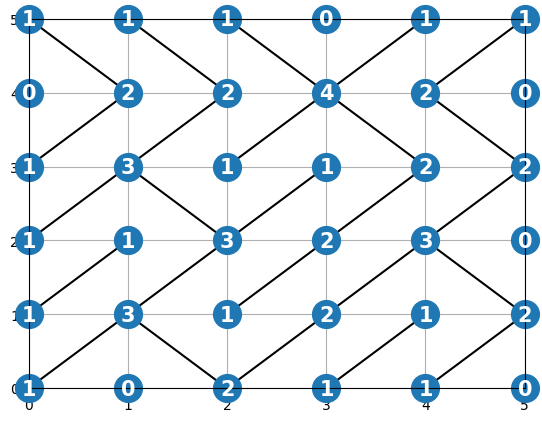

In [126]:
x = [0,0,1,1,2,2,2,3,3,4,4,5,5,5]
y = [0,2,1,4,1,2,4,2,4,2,3,0,2,4]
val = [1,1,3,2,1,3,2,2,4,3,2,0,0,0]

plt.xlim(0,5)
plt.ylim(0,5)

for i,j in totals.keys():
  plt.scatter(i,j,marker = 'o', color = '#1f77b4', s = 400, clip_on=False, alpha = 1, zorder = 2)
  plt.text(i-.07,j-.09,int(totals[i,j]), color = '#FFFFFF', fontsize = 15, weight = 'semibold', zorder = 3)


for i,j in sol.keys():
  if sol[i,j] == 1:
    plt.plot((i,i+1),(j,j+1), color = 'k', zorder = 0)
  else:
    plt.plot((i+1,i),(j,j+1),color = 'k', zorder = 0)

plt.grid(True, which = 'major', zorder = 1)
#plt.savefig('finished.png')
plt.show()